<a href="https://colab.research.google.com/github/MohuaSinha/EVA4/blob/master/S9/S9_Solution_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "//content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library"
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library'
sys.path.append(workingdir)

/content/gdrive/My Drive/Colab Notebooks/EVA4/Mou_Library


In [3]:
ls-ltr

total 62
-rw------- 1 root root 10701 Mar 14 15:13 dnnmodel.ipynb
drwx------ 3 root root  4096 Mar 14 15:38 data/
-rw------- 1 root root  4156 Mar 14 16:48 train_test.ipynb
-rw------- 1 root root   791 Mar 19 07:11 displayimages.py
-rw------- 1 root root  2515 Mar 19 07:11 showimages.py
drwx------ 2 root root  4096 Mar 19 07:16 __pycache__/
-rw------- 1 root root  2808 Mar 21 19:12 datatransformation_old.py
-rw------- 1 root root  6346 Mar 21 19:33 datatransformation.ipynb
-rw------- 1 root root  9276 Mar 21 20:01 dnnmodel_old.py
-rw------- 1 root root  3140 Mar 21 20:05 train_test_old.py
-rw------- 1 root root  2227 Mar 21 20:39 utils.ipynb
-rw------- 1 root root  6226 Mar 21 20:48 gradcam.ipynb
-rw------- 1 root root  4057 Mar 21 20:52 visualize.ipynb



Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [4]:
!pip install import-ipynb
import import_ipynb
#from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import os

#Below are the created modules
import dnnmodel 
import train_test
import datatransformation 
import showimages
import displayimages
import gradcam
#import visualize 
import utils
from torch.optim.lr_scheduler import StepLR

importing Jupyter notebook from dnnmodel.ipynb
importing Jupyter notebook from train_test.ipynb
importing Jupyter notebook from datatransformation.ipynb
importing Jupyter notebook from gradcam.ipynb
importing Jupyter notebook from utils.ipynb


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
#train_transforms,test_transforms= datatransformation.load()
train_transforms , test_transforms=datatransformation.AlbumentationWrapper('train'), datatransformation.AlbumentationWrapper('test')

In [6]:
classes,trainloader, testloader = datatransformation.dataloaders(1, 128, 10, train_transforms , test_transforms)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat   cat


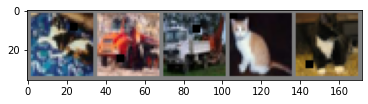

In [7]:
displayimages.show_random_image(trainloader,classes)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = dnnmodel.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
EPOCHS =30
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test.train(model, device, trainloader, optimizer, epoch,False)
    train_test.test(model, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.9260574579238892 Batch_id=390 Accuracy=51.28: 100%|██████████| 391/391 [00:58<00:00,  6.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 5783/10000 (57.83%)

EPOCH: 1


Loss=0.7183085083961487 Batch_id=390 Accuracy=71.25: 100%|██████████| 391/391 [01:01<00:00,  6.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7306/10000 (73.06%)

EPOCH: 2


Loss=0.47686395049095154 Batch_id=390 Accuracy=78.78: 100%|██████████| 391/391 [01:03<00:00,  6.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 7782/10000 (77.82%)

EPOCH: 3


Loss=0.5581607818603516 Batch_id=390 Accuracy=82.75: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8056/10000 (80.56%)

EPOCH: 4


Loss=0.41380009055137634 Batch_id=390 Accuracy=85.57: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8282/10000 (82.82%)

EPOCH: 5


Loss=0.2785283923149109 Batch_id=390 Accuracy=87.52: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8116/10000 (81.16%)

EPOCH: 6


Loss=0.4753034710884094 Batch_id=390 Accuracy=89.13: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8277/10000 (82.77%)

EPOCH: 7


Loss=0.3959176540374756 Batch_id=390 Accuracy=90.76: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8366/10000 (83.66%)

EPOCH: 8


Loss=0.29376673698425293 Batch_id=390 Accuracy=92.00: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8337/10000 (83.37%)

EPOCH: 9


Loss=0.20889189839363098 Batch_id=390 Accuracy=93.12: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8310/10000 (83.10%)

EPOCH: 10


Loss=0.17271757125854492 Batch_id=390 Accuracy=93.99: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8475/10000 (84.75%)

EPOCH: 11


Loss=0.1796124279499054 Batch_id=390 Accuracy=94.66: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8363/10000 (83.63%)

EPOCH: 12


Loss=0.22027942538261414 Batch_id=390 Accuracy=95.31: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8391/10000 (83.91%)

EPOCH: 13


Loss=0.1857127845287323 Batch_id=390 Accuracy=95.63: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8408/10000 (84.08%)

EPOCH: 14


Loss=0.03290221840143204 Batch_id=390 Accuracy=96.44: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8542/10000 (85.42%)

EPOCH: 15


Loss=0.08818648010492325 Batch_id=390 Accuracy=96.83: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8525/10000 (85.25%)

EPOCH: 16


Loss=0.06005304306745529 Batch_id=390 Accuracy=97.23: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8564/10000 (85.64%)

EPOCH: 17


Loss=0.09638966619968414 Batch_id=390 Accuracy=97.32: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8511/10000 (85.11%)

EPOCH: 18


Loss=0.1197061538696289 Batch_id=390 Accuracy=97.41: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8503/10000 (85.03%)

EPOCH: 19


Loss=0.058803509920835495 Batch_id=390 Accuracy=97.62: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8585/10000 (85.85%)

EPOCH: 20


Loss=0.03944813087582588 Batch_id=390 Accuracy=98.11: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8499/10000 (84.99%)

EPOCH: 21


Loss=0.04300152510404587 Batch_id=390 Accuracy=98.07: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8548/10000 (85.48%)

EPOCH: 22


Loss=0.05049055814743042 Batch_id=390 Accuracy=98.21: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8582/10000 (85.82%)

EPOCH: 23


Loss=0.052081894129514694 Batch_id=390 Accuracy=98.30: 100%|██████████| 391/391 [01:04<00:00,  6.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8662/10000 (86.62%)

EPOCH: 24


Loss=0.07336470484733582 Batch_id=390 Accuracy=98.26: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8729/10000 (87.29%)

EPOCH: 25


Loss=0.014298021793365479 Batch_id=390 Accuracy=98.71: 100%|██████████| 391/391 [01:03<00:00,  6.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8515/10000 (85.15%)

EPOCH: 26


Loss=0.012891369871795177 Batch_id=390 Accuracy=98.50: 100%|██████████| 391/391 [01:03<00:00,  6.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8607/10000 (86.07%)

EPOCH: 27


Loss=0.03555091470479965 Batch_id=390 Accuracy=98.87: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8599/10000 (85.99%)

EPOCH: 28


Loss=0.029063111171126366 Batch_id=390 Accuracy=98.70: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8659/10000 (86.59%)

EPOCH: 29


Loss=0.13463814556598663 Batch_id=390 Accuracy=98.80: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]



Test set: Average loss: 0.0038, Accuracy: 8708/10000 (87.08%)



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   ship horse plane  bird   dog
Predicted:   ship horse plane  bird   dog


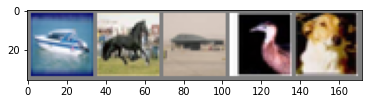

In [11]:
showimages.show_predicted_actual(model, device, testloader, classes)

Okay, now let us see what the neural network thinks these examples above are:



The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [12]:
#Visualize GradCam
import visualize
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradcam_visualize.VisualizeCam(model,data.classes, target_layers)

importing Jupyter notebook from visualize.ipynb
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


KeyError: ignored

In [0]:
#GradCam for correctly classified images
num_img = 5
correct_pred_imgs = []
for i in range(num_img):
  correct_pred_imgs.append(torch.as_tensor(correct_imgs[i]["img"]))
viz_cam(torch.stack(correct_pred_imgs), target_layers, metric="correct")

The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
showimages.evaluate_accuracy(model, device, testloader)

That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
showimages.evaluate_classwise_accuracy(model, device, classes, testloader)